**Enviorement Preparation :**




In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz
#!pip install pydantic==1.10.12 # Install a compatible Pydantic version
!pip install mysql-connector-python
import requests
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_ner_bc5cdr_md: filename=en_ner_bc5cdr_md-0.5.4-py3-none-any.whl size=119787678 sha256=a130448f9da219514e5a894f13e091fbdcd6c42ae60f931040186f47e84be4a3
  Stored in directory: /root/.cache/pip/wheels/6e/a6/d6/bd15a41e2ff02a62f0a0a48dddbc07d048307db7199a1538f7
Successfully built en_ner_bc5cdr_md
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.0/34.0 MB 12.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Connection to DB Preparation :**

In [ ]:
import mysql.connector
def connect_to_mysql():
    """
    Connect to MySQL database and return the connection object.
    """
    return mysql.connector.connect(
        user='NLPUSER',
        password='Nlpuser@2025',
        host='SG-Mysql-DB-11663-mysql-master.servers.mongodirector.com',
        database='NLP-MEDIC-DB',
        charset="utf8mb4",
        collation="utf8mb4_unicode_ci"
    )

**Fetch Prescription Data**

In [ ]:
# Base URL for OpenFDA API
OPENFDA_BASE_URL = "https://api.fda.gov/drug/label.json"

def fetch_prescription_data(limit=100, skip=0):
    """
    Fetch prescription-related data (medications, dosages, indications).

    Args:
        limit (int): Number of records to fetch per request.
        skip (int): Number of records to skip for pagination.

    Returns:
        list: List of prescription-related data.
    """
    url = OPENFDA_BASE_URL
    params = {"limit": limit, "skip": skip}
    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json().get("results", [])
    else:
        print(f"Error fetching data: {response.status_code}")
        return []

def fetch_all_prescription_data():
    """
    Fetch all prescription-related data from the OpenFDA API.

    Returns:
        list: List of all prescription-related data.
    """
    all_data = []
    skip = 0
    limit = 1000  # Number of records per request

    while True:
        print(f"Fetching data: skip={skip}, limit={limit}")
        batch = fetch_prescription_data(limit=limit, skip=skip)

        if not batch:  # Stop if no more data is returned
            break

        all_data.extend(batch)
        skip += limit  # Update skip for the next batch

    return all_data

# Fetch all prescription data
all_prescription_data = fetch_all_prescription_data()

# Print the total number of records fetched
print(f"Total records fetched: {len(all_prescription_data)}")

Fetching data: skip=0, limit=1000
Fetching data: skip=1000, limit=1000
Fetching data: skip=2000, limit=1000
Fetching data: skip=3000, limit=1000
Fetching data: skip=4000, limit=1000
Fetching data: skip=5000, limit=1000
Fetching data: skip=6000, limit=1000
Fetching data: skip=7000, limit=1000
Fetching data: skip=8000, limit=1000
Fetching data: skip=9000, limit=1000
Fetching data: skip=10000, limit=1000
Fetching data: skip=11000, limit=1000
Fetching data: skip=12000, limit=1000
Fetching data: skip=13000, limit=1000
Fetching data: skip=14000, limit=1000
Fetching data: skip=15000, limit=1000
Fetching data: skip=16000, limit=1000
Fetching data: skip=17000, limit=1000
Fetching data: skip=18000, limit=1000
Fetching data: skip=19000, limit=1000
Fetching data: skip=20000, limit=1000
Fetching data: skip=21000, limit=1000
Fetching data: skip=22000, limit=1000
Fetching data: skip=23000, limit=1000
Fetching data: skip=24000, limit=1000
Fetching data: skip=25000, limit=1000
Fetching data: skip=26000

In [ ]:
prescription_data = all_prescription_data

**Process Prescription Data (Extraction)**

In [ ]:

def process_prescription_data(data, max_generic_name_length=255):
    """
    Process raw prescription data into a structured format (focusing on drugs, dosages, and diseases).

    Args:
        data (list): Raw data from OpenFDA API.

    Returns:
        pd.DataFrame: Processed prescription data as a pandas DataFrame.
    """
    processed_data = []
    for item in data:
        generic_name = item.get("openfda", {}).get("generic_name", ["N/A"])[0]
        if len(generic_name) > max_generic_name_length:
            generic_name = generic_name[:max_generic_name_length]
        processed_data.append({
            "Brand Name": item.get("openfda", {}).get("brand_name", ["N/A"])[0],
            "Generic Name": generic_name,
            "Manufacturer Name": item.get("openfda", {}).get("manufacturer_name", ["N/A"])[0],
            "Indications and Usage": " ".join(item.get("indications_and_usage", ["N/A"])),
            "Dosage and Administration": " ".join(item.get("dosage_and_administration", ["N/A"]))
        })
    return pd.DataFrame(processed_data)

df_prescription_data = process_prescription_data(prescription_data)
df_prescription_data.head()


,Brand Name,Generic Name,Manufacturer Name,Indications and Usage,Dosage and Administration
0,SILICEA,SILICEA,"Rxhomeo Private Limited d.b.a. Rxhomeo, Inc",INDICATIONS Condition listed above or as direc...,"DOSAGE Adults- Take 4 or 6 Pellets by mouth, t..."
1,N/A,N/A,N/A,Uses Multi-purpose mineral powder provides bro...,Directions Protection Naturelle SPF 46 PA+++ P...
2,Betadine,POVIDONE-IODINE,"Atlantis Consumer Healthcare, Inc.",Uses First aid to help prevent infection in mi...,Directions clean the affected area spray a sma...
3,N/A,N/A,N/A,INDICATIONS Indications: MEZEREUM Itching,DIRECTIONS Adults: Dissolve 3 to 5 under the t...
4,N/A,N/A,N/A,INDICATIONS AND USAGE Ofloxacin ophthalmic sol...,DOSAGE AND ADMINISTRATION The recommended dosa...


**Text Normalization (Cleaning) - Lowercasing, Removing Punctuation, and Stopwords**

In [ ]:

def clean_text(text):
    """
    Normalize text: convert to lowercase, remove punctuation, and remove stopwords.

    Args:
        text (str): The input text.

    Returns:
        str: The cleaned text.
    """
    text = text.lower()


    text = text.translate(str.maketrans("", "", string.punctuation))


    stop_words = set(stopwords.words("english"))
    text_tokens = text.split()
    filtered_text = " ".join([word for word in text_tokens if word not in stop_words])

    return filtered_text


df_prescription_data['Cleaned Indications and Usage'] = df_prescription_data['Indications and Usage'].apply(clean_text)
df_prescription_data['Cleaned Dosage and Administration'] = df_prescription_data['Dosage and Administration'].apply(clean_text)


df_prescription_data[['Brand Name', 'Generic Name', 'Cleaned Indications and Usage', 'Cleaned Dosage and Administration']].head()


,Brand Name,Generic Name,Cleaned Indications and Usage,Cleaned Dosage and Administration
0,SILICEA,SILICEA,indications condition listed directed physician,dosage adults take 4 6 pellets mouth three tim...
1,N/A,N/A,uses multipurpose mineral powder provides broa...,directions protection naturelle spf 46 pa powd...
2,Betadine,POVIDONE-IODINE,uses first aid help prevent infection minor cu...,directions clean affected area spray small amo...
3,N/A,N/A,indications indications mezereum itching,directions adults dissolve 3 5 tongue three ti...
4,N/A,N/A,indications usage ofloxacin ophthalmic solutio...,dosage administration recommended dosage regim...


In [ ]:
len(df1)

6720

In [ ]:
df_cleaned=df_prescription_data
df_cleaned.replace("N/A", pd.NA, inplace=True)
df_cleaned =df_cleaned.dropna(subset=["Generic Name", "Brand Name"], how="all")
df_cleaned = df_cleaned.drop_duplicates(subset=["Brand Name", "Generic Name"], keep=False)
df1=df_cleaned
df1.head()


,Brand Name,Generic Name,Manufacturer Name,Indications and Usage,Dosage and Administration,Cleaned Indications and Usage,Cleaned Dosage and Administration
2,Betadine,POVIDONE-IODINE,"Atlantis Consumer Healthcare, Inc.",Uses First aid to help prevent infection in mi...,Directions clean the affected area spray a sma...,uses first aid help prevent infection minor cu...,directions clean affected area spray small amo...
10,Quick Action,SALICYLIC ACID,Equate,Uses for the treatment of acne,"Directions wet face, apply to hand, massage fa...",uses treatment acne,directions wet face apply hand massage face ge...
11,Cuprum aceticum Nicotiana,CUPRUM ACETICUM NICOTIANA,Uriel Pharmacy Inc.,Directions: FOR ORAL USE ONLY.,Dissolve pellets under the tongue 3-4 times da...,directions oral use,dissolve pellets tongue 34 times daily ages 12...
12,Mekinist,TRAMETINIB,Novartis Pharmaceuticals Corporation,1 INDICATIONS AND USAGE MEKINIST is a kinase i...,2 DOSAGE AND ADMINISTRATION The recommended do...,1 indications usage mekinist kinase inhibitor ...,2 dosage administration recommended dosage mek...
17,anti itch,HYDROCORTISONE,"Meijer, Inc.",Uses • temporarily relieves itching associated...,"Directions • for itching of skin irritation, i...",uses • temporarily relieves itching associated...,directions • itching skin irritation inflammat...


In [ ]:
def insert_data_to_mysql(df1):
    """
    Insert the processed and vectorized data into MySQL database.

    Args:
        df (pd.DataFrame): The DataFrame with processed and vectorized features.
    """
    try:

        connection = connect_to_mysql()
        cursor = connection.cursor()


        cursor.execute("""
            CREATE TABLE IF NOT EXISTS medication_data (
                id INT AUTO_INCREMENT PRIMARY KEY,
                brand_name TEXT,
                generic_name TEXT,
                dosage_and_administration TEXT
            )
        """)

        for index, row in df1.iterrows():
            query = """
                INSERT INTO medication_data
                (brand_name,generic_name,dosage_and_administration)
                VALUES (%s, %s, %s)
            """
            data = (
                row["Brand Name"],
                row["Generic Name"],
                row["Cleaned Dosage and Administration"]
            )

            cursor.execute(query, data)

        connection.commit()
        print(f"Data inserted into the database successfully.")

    except mysql.connector.Error as err:
        print(f"Error: {err}")
    finally:
        cursor.close()
        connection.close()

insert_data_to_mysql(df1)

Data inserted into the database successfully.


Tokenization and TF-IDF Vectorization

In [ ]:

def vectorize_text(df):
    """
    Tokenize and vectorize text using TF-IDF.

    Args:
        df (pd.DataFrame): The DataFrame containing cleaned text data.

    Returns:
        pd.DataFrame: The DataFrame with vectorized features.
    """

    tfidf_vectorizer = TfidfVectorizer(max_features=5000)

    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Cleaned Indications and Usage'])

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    df = pd.concat([df, tfidf_df], axis=1)

    return df


df_vectorized = vectorize_text(df_prescription_data)


df_vectorized.head()


,Brand Name,Generic Name,Manufacturer Name,Indications and Usage,Dosage and Administration,Cleaned Indications and Usage,Cleaned Dosage and Administration,00254,005,01,...,zoloft,zolpidem,zoster,zyprexa,ßlactamaseproducing,βhemolytic,βlactam,βlactamase,βlactamasenegative,βlactamaseproducing
0,SILICEA,SILICEA,"Rxhomeo Private Limited d.b.a. Rxhomeo, Inc",INDICATIONS Condition listed above or as direc...,"DOSAGE Adults- Take 4 or 6 Pellets by mouth, t...",indications condition listed directed physician,dosage adults take 4 6 pellets mouth three tim...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,<NA>,<NA>,<NA>,Uses Multi-purpose mineral powder provides bro...,Directions Protection Naturelle SPF 46 PA+++ P...,uses multipurpose mineral powder provides broa...,directions protection naturelle spf 46 pa powd...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Betadine,POVIDONE-IODINE,"Atlantis Consumer Healthcare, Inc.",Uses First aid to help prevent infection in mi...,Directions clean the affected area spray a sma...,uses first aid help prevent infection minor cu...,directions clean affected area spray small amo...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,<NA>,<NA>,<NA>,INDICATIONS Indications: MEZEREUM Itching,DIRECTIONS Adults: Dissolve 3 to 5 under the t...,indications indications mezereum itching,directions adults dissolve 3 5 tongue three ti...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,<NA>,<NA>,<NA>,INDICATIONS AND USAGE Ofloxacin ophthalmic sol...,DOSAGE AND ADMINISTRATION The recommended dosa...,indications usage ofloxacin ophthalmic solutio...,dosage administration recommended dosage regim...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


MySQL Database Insertion

**NER with spaCy :**

In [ ]:
import hashlib
import hmac
import base64

# API credentials
api_key = "amanisouai.dev@gmail.com"
secret_key = "y9PKf86Qse5NFb4n3"
auth_url = "https://sandbox-authservice.priaid.ch/login"

# Compute HMAC-MD5 hash
def compute_hmac_md5(secret, uri):
    secret_bytes = secret.encode('utf-8')
    uri_bytes = uri.encode('utf-8')
    hmac_md5 = hmac.new(secret_bytes, uri_bytes, hashlib.md5).digest()
    return base64.b64encode(hmac_md5).decode()

# Generate the hashed credentials
hashed_credentials = compute_hmac_md5(secret_key, auth_url)

# Set up headers
headers = {
    "Authorization": f"Bearer {api_key}:{hashed_credentials}"
}

# Send POST request to obtain the token
response = requests.post(auth_url, headers=headers)

# Check response status and print the token
if response.status_code == 200:
    token_data = response.json()
    print("Access Token:", token_data["Token"])
    print("Valid Through (seconds):", token_data["ValidThrough"])
else:
    print("Failed to authenticate:", response.text)


Access Token: eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJlbWFpbCI6ImFtYW5pc291YWkuZGV2QGdtYWlsLmNvbSIsInJvbGUiOiJVc2VyIiwiaHR0cDovL3NjaGVtYXMueG1sc29hcC5vcmcvd3MvMjAwNS8wNS9pZGVudGl0eS9jbGFpbXMvc2lkIjoiMTQ0MTAiLCJodHRwOi8vc2NoZW1hcy5taWNyb3NvZnQuY29tL3dzLzIwMDgvMDYvaWRlbnRpdHkvY2xhaW1zL3ZlcnNpb24iOiIyMDAiLCJodHRwOi8vZXhhbXBsZS5vcmcvY2xhaW1zL2xpbWl0IjoiOTk5OTk5OTk5IiwiaHR0cDovL2V4YW1wbGUub3JnL2NsYWltcy9tZW1iZXJzaGlwIjoiUHJlbWl1bSIsImh0dHA6Ly9leGFtcGxlLm9yZy9jbGFpbXMvbGFuZ3VhZ2UiOiJlbi1nYiIsImh0dHA6Ly9zY2hlbWFzLm1pY3Jvc29mdC5jb20vd3MvMjAwOC8wNi9pZGVudGl0eS9jbGFpbXMvZXhwaXJhdGlvbiI6IjIwOTktMTItMzEiLCJodHRwOi8vZXhhbXBsZS5vcmcvY2xhaW1zL21lbWJlcnNoaXBzdGFydCI6IjIwMjUtMDEtMjkiLCJpc3MiOiJodHRwczovL3NhbmRib3gtYXV0aHNlcnZpY2UucHJpYWlkLmNoIiwiYXVkIjoiaHR0cHM6Ly9oZWFsdGhzZXJ2aWNlLnByaWFpZC5jaCIsImV4cCI6MTczODQwOTMyOSwibmJmIjoxNzM4NDAyMTI5fQ.QqBZvIw8rmTJ5EC1lUgGN6LxAJfMRCrznpoyR3oaA9s
Valid Through (seconds): 7200


In [ ]:
import spacy
nlp = spacy.load("en_ner_bc5cdr_md")
print("Model loaded successfully!")
print(nlp.pipe_labels)

/usr/local/lib/python3.11/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


Model loaded successfully!
{'tok2vec': [], 'tagger': ['$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'ADD', 'AFX', 'CC', 'CD', 'DT', 'EX', 'FW', 'HYPH', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NFP', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', 'XX', '``'], 'attribute_ruler': [], 'lemmatizer': [], 'parser': ['ROOT', 'acl', 'acl:relcl', 'acomp', 'advcl', 'advmod', 'amod', 'amod@nmod', 'appos', 'attr', 'aux', 'auxpass', 'case', 'cc', 'cc:preconj', 'ccomp', 'compound', 'compound:prt', 'conj', 'cop', 'csubj', 'dative', 'dep', 'det', 'det:predet', 'dobj', 'expl', 'intj', 'mark', 'meta', 'mwe', 'neg', 'nmod', 'nmod:npmod', 'nmod:poss', 'nmod:tmod', 'nsubj', 'nsubjpass', 'nummod', 'parataxis', 'pcomp', 'pobj', 'preconj', 'predet', 'prep', 'punct', 'quantmod', 'xcomp'], 'ner': ['CHEMICAL', 'DISEASE']}


In [ ]:
TOKEN= token_data["Token"]
# Function to extract named entities
def fetch_symptoms_from_api():
    """
    Fetch the list of symptoms from the API.

    Returns:
        list: A list of symptom names.
    """
    url = f"https://sandbox-healthservice.priaid.ch/symptoms?token={TOKEN}&language=en-gb"
    response = requests.get(url)
    if response.status_code == 200:
        symptoms = response.json()
        return [symptom["Name"].lower() for symptom in symptoms]  # Extract symptom names and convert to lowercase
    else:
        print(f"Failed to fetch symptoms: {response.status_code}")
        return []
# Fetch symptoms from the API
symptom_list = fetch_symptoms_from_api()

**Apply Model spacy : using pretrained en_ner_bc5cdr_md**

In [ ]:
import pandas as pd
def extract_entities(text):
    """
    Extract entities related to symptoms, diseases, and medications.
    Also retrieves dosage and administration details for medications.

    Args:
        text (str): The input text.

    Returns:
        dict: A dictionary with entities grouped by type, including dosage details.
    """
    doc = nlp(text)
    entities = {"SYMPTOMS": [], "DISEASES": [], "MEDICATIONS": []}

    for ent in doc.ents:
        if ent.label_ == "DISEASE":  # Extract diseases
            entities["DISEASES"].append(ent.text)
        elif ent.label_ == "CHEMICAL":  # Extract medications
            medication_name = ent.text
            entities["MEDICATIONS"].append(medication_name)

    # Extract symptoms by checking for matches in the text
    for symptom in symptom_list:
        if symptom in text.lower():
            entities["SYMPTOMS"].append(symptom)

    return entities


# Apply the function to your DataFrame
df_prescription_data['Extracted Entities'] = df_prescription_data['Cleaned Indications and Usage'].apply(extract_entities)
# Split the 'Extracted Entities' column into separate columns
df_prescription_data['SYMPTOMS'] = df_prescription_data['Extracted Entities'].apply(lambda x: ', '.join(x['SYMPTOMS']))
df_prescription_data['DISEASES'] = df_prescription_data['Extracted Entities'].apply(lambda x: ', '.join(x['DISEASES']))
df_prescription_data['MEDICATIONS'] = df_prescription_data['Extracted Entities'].apply(lambda x: ', '.join(x['MEDICATIONS']))

# Drop the original 'Extracted Entities' column
df_prescription_data.drop(columns=['Extracted Entities'], inplace=True)
# View the extracted entities



In [ ]:
df_prescription_data[['SYMPTOMS','DISEASES','MEDICATIONS']]


,SYMPTOMS,DISEASES,MEDICATIONS
0,,,
1,,,
2,,infection,
3,,mezereum itching,
4,,infections,ofloxacin
...,...,...,...
25995,sweating,"skin cancer, skin aging decrease",
25996,,diabetes mellitus,metformin hydrochloride
25997,,"rheumatoid arthritis, spondylitis, osteoarthri...","indomethacin extendedrelease, indomethacin ext..."
25998,,,


In [ ]:
df_prescription_data["MEDICATIONS"].isna().sum() + df_prescription_data["MEDICATIONS"].eq('').sum()

3606

Insert to DB **prescription_data**

In [ ]:
def insert_data_to_mysql(df):
    """
    Insert the processed and vectorized data into MySQL database.

    Args:
        df (pd.DataFrame): The DataFrame with processed and vectorized features.
    """
    try:

        connection = connect_to_mysql()
        cursor = connection.cursor()


        cursor.execute("""
            CREATE TABLE IF NOT EXISTS prescription_data (
                id INT AUTO_INCREMENT PRIMARY KEY,
                cleaned_indications_and_usage TEXT,
                symptoms TEXT,
                diseases TEXT,
                medications TEXT
            )
        """)

        for index, row in df.iterrows():
            query = """
                INSERT INTO prescription_data
                (cleaned_indications_and_usage,symptoms ,diseases, medications)
                VALUES (%s, %s, %s, %s)
            """
            data = (
                row["Cleaned Indications and Usage"],
                row["SYMPTOMS"],
                row["DISEASES"],
                row["MEDICATIONS"]
            )

            cursor.execute(query, data)

        connection.commit()
        print(f"Data inserted into the database successfully.")

    except mysql.connector.Error as err:
        print(f"Error: {err}")
    finally:
        cursor.close()
        connection.close()

insert_data_to_mysql(df_prescription_data)

Data inserted into the database successfully.


In [ ]:
import mysql.connector

def fetch_data_from_mysql():
    """
    Fetch and display data from the MySQL table.
    """
    try:
        connection = mysql.connector.connect(
          user='NLPUSER',
          password='Nlpuser@2025',
          host='SG-Mysql-DB-11663-mysql-master.servers.mongodirector.com',
          database='NLP-MEDIC-DB',
          charset="utf8mb4",
          collation="utf8mb4_unicode_ci"
        )
        cursor = connection.cursor()

        # Select all data from the table
        query = "SELECT * FROM medication_data where generic_name='nicotine acetate'OR brand_name='nicotine' ;"  # Fetch first 10 rows
        cursor.execute(query)

        # Fetch all rows
        rows = cursor.fetchall()

        # Get column names
        column_names = [desc[0] for desc in cursor.description]

        # Display results
        print("Fetched Data:")
        print(column_names)
        for row in rows:
            print(row)

    except mysql.connector.Error as err:
        print(f"Error: {err}")

    finally:
        cursor.close()
        connection.close()

# Call function to check data
fetch_data_from_mysql()

Fetched Data:
['id', 'brand_name', 'generic_name', 'dosage_and_administration']
(1719, 'nicotine', 'NICOTINE', 'directions • 18 years age ask doctor use studies done show product work • using product read enclosed user’s guide complete directions important information • begin using lozenge quit day • smoke first cigarette within 30 minutes waking use 4 mg nicotine lozenge • smoke first cigarette 30 minutes waking use 2 mg nicotine lozenge according following 12 week schedule weeks 1 6 weeks 7 9 weeks 10 12 1 lozenge every 1 2 hours 1 lozenge every 2 4 hours 1 lozenge every 4 8 hours • nicotine lozenge medicine must used certain way get best results • place lozenge mouth allow lozenge slowly dissolve minimize swallowing chew swallow lozenge • may feel warm tingling sensation • occasionally move lozenge one side mouth completely dissolved • eat drink 15 minutes using lozenge mouth • improve chances quitting use least 9 lozenges per day first 6 weeks • use one lozenge time continuously us

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Count occurrences of each symptom-disease pair
df_prescription_data = df_prescription_data[df_prescription_data["SYMPTOMS"].notna() & (df_prescription_data["SYMPTOMS"] != "")]
symptom_disease_counts = df_prescription_data.groupby(["SYMPTOMS", "DISEASES"]).size().reset_index(name="Count")

# Sort by count
symptom_disease_counts = symptom_disease_counts.sort_values(by="Count", ascending=False)

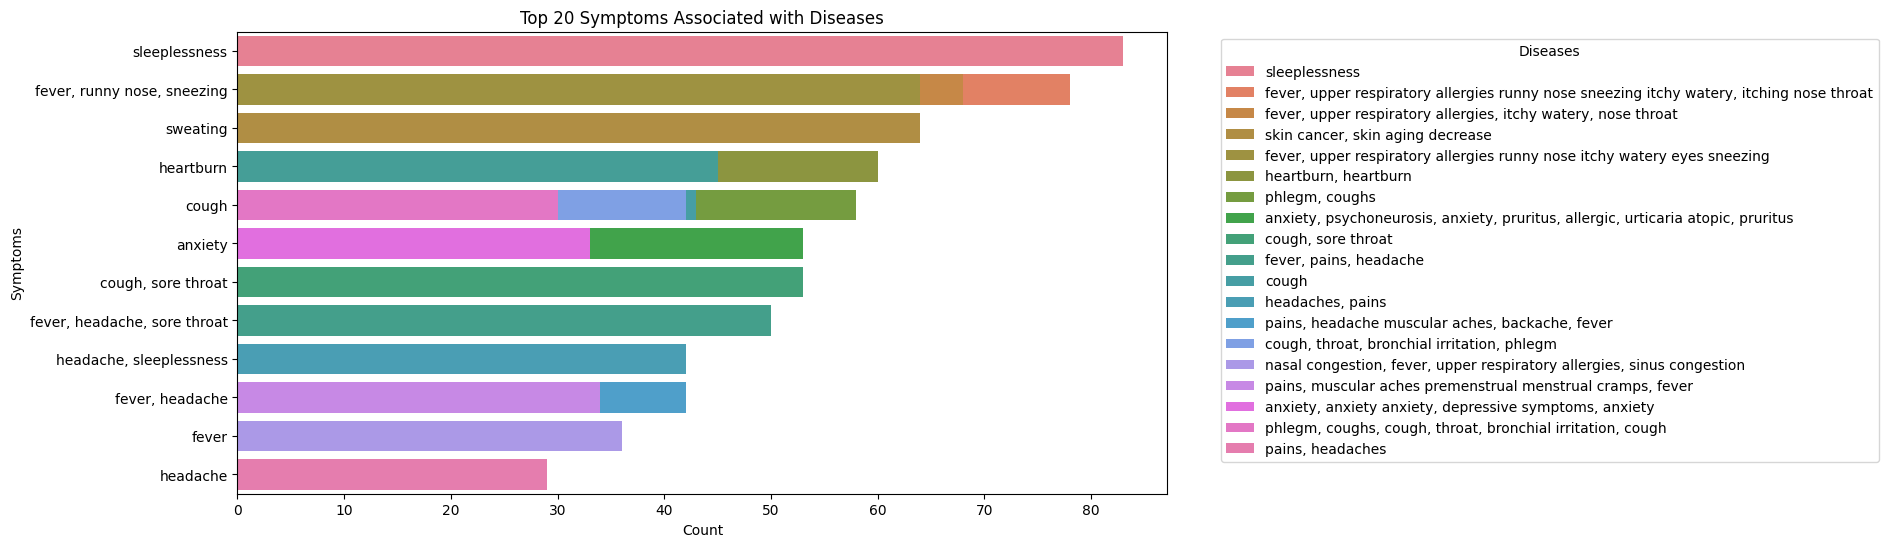

In [ ]:
# Set figure size
plt.figure(figsize=(12, 6))

# Plot using Seaborn
sns.barplot(
    data=symptom_disease_counts.head(20),  # Show top 20 pairs
    x="Count",
    y="SYMPTOMS",
    hue="DISEASES",
    dodge=False
)

# Labels and Title
plt.xlabel("Count")
plt.ylabel("Symptoms")
plt.title("Top 20 Symptoms Associated with Diseases")
plt.legend(title="Diseases", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
df = df_prescription_data
# Step 1: Drop rows where SYMPTOMS is empty
df = df[df["SYMPTOMS"].notna() & (df["SYMPTOMS"] != "")]

# Step 2: Feature Extraction (TF-IDF)
tfidf = TfidfVectorizer(max_features=20000)  # Adjust max_features as needed
X = tfidf.fit_transform(df["SYMPTOMS"])

# Step 3: Label Encoding
le = LabelEncoder()
y = le.fit_transform(df["DISEASES"])

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train an SVM model
svm_model = SVC(kernel="linear")  # You can try other kernels like 'rbf'
svm_model.fit(X_train, y_train)


# Step 6: Evaluate the model
y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Get unique labels from y_test and y_pred
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Filter target names to match the unique labels
target_names = le.classes_[unique_labels]

# Generate classification report with filtered target names
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names))

Accuracy: 0.1748046875
Classification Report:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
df_prescription_data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Step 6: Save the Model and Vectorizer
vectorizer = TfidfVectorizer()
joblib.dump(svm_model, "svm_symptom_classifier.pkl")
joblib.dump(vectorizer, "symptom_vectorizer.pkl")

print("SVM model and vectorizer saved successfully.")

SVM model and vectorizer saved successfully.


Classification with symptoms

Using bert model

In [ ]:
import joblib

joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [ ]:
!curl ifconfig.me

35.233.227.72

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd

# Load the pre-trained BioBERT model and tokenizer
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Create a pipeline for NER
ner_pipeline = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple",  # Handles grouped entities
)

# Function to extract entities
def extract_ner_entities(text):
    """
    Extract entities from text using a BERT-based NER model.

    Args:
        text (str): Input text.

    Returns:
        dict: Dictionary of extracted entities by type.
    """
    # Split text into smaller chunks to avoid exceeding model limits
    max_length = 512
    tokens = tokenizer(text, truncation=True, max_length=max_length, return_tensors="pt")

    entities = {"SYMPTOMS": [], "DISEASES": [], "MEDICATIONS": []}

    for token_chunk in tokens["input_ids"]:
        chunk_text = tokenizer.decode(token_chunk, skip_special_tokens=True)
        ner_results = ner_pipeline(chunk_text)

        for entity in ner_results:
            label = entity.get("entity_group", "").lower()
            entity_text = entity.get("word", "").strip()

            # Map entity types to categories
            if label in ["disease", "condition"]:  # Adjust based on model output
                entities["DISEASES"].append(entity_text)
            elif label in ["chemical", "drug"]:
                entities["MEDICATIONS"].append(entity_text)
            elif label == "symptom":
                entities["SYMPTOMS"].append(entity_text)

    return entities


# Apply NER extraction to the dataset
df_prescription_data["Extracted Entities"] = df_prescription_data["Cleaned Indications and Usage"].apply(extract_ner_entities)

# Display results
# View the extracted entities
df_prescription_data[['Brand Name', 'Generic Name','Cleaned Indications and Usage', 'Extracted Entities']]


In [ ]:
!pip install transformers datasets torch scikit-learn

In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Step 1: Load your dataset
data = {
    "Symptoms": [
        "Fever, headache, and fatigue",
        "Shortness of breath and chest pain",
        "Nausea, vomiting, and abdominal pain",
        "Sneezing and runny nose",
    ],
    "Class": ["Flu", "Heart Issue", "Stomach Issue", "Cold"]
}
df = pd.DataFrame(data)

# Step 2: Map classes to integers
class_labels = {label: i for i, label in enumerate(df["Class"].unique())}
df["label"] = df["Class"].map(class_labels)

# Step 3: Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Symptoms"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

# Step 4: Tokenize the dataset
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Convert to PyTorch Datasets
train_dataset = Dataset.from_dict({"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"], "labels": train_labels})
test_dataset = Dataset.from_dict({"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"], "labels": test_labels})

# Step 5: Define the model
num_labels = len(class_labels)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

# Step 6: Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Step 7: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Step 8: Train the model
trainer.train()

# Step 9: Test the model
predictions = trainer.predict(test_dataset)
predicted_classes = [list(class_labels.keys())[pred] for pred in predictions.predictions.argmax(axis=1)]

# Display results
for text, pred_class in zip(test_texts, predicted_classes):
    print(f"Text: {text} => Predicted Class: {pred_class}")


In [ ]:
!pip install pydantic==1.8.2


In [ ]:
import openai
import pandas as pd

# Set up your API key
openai.api_key = "sk-r3S1z6s0PSseL3diQazFLKRMdRnzsDoR4VfaoDj6bCT3BlbkFJjxASDu0r0pXM8whRS-OkTQ5G42QF7qyeXCBX9kLMsA"

def extract_entities_gpt(text):
    """
    Use GPT-3.5-Turbo to extract symptoms, diseases, and medications from the text.

    Args:
        text (str): The input text.

    Returns:
        dict: A dictionary with extracted entities.
    """
    prompt = f"""
    Extract the following entities from the text:
    - Symptoms
    - Diseases
    - Medications
    Text: {text}
    Format the response as a JSON object with keys "SYMPTOMS", "DISEASES", and "MEDICATIONS".
    """

    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an assistant specialized in entity extraction."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=200
    )

    # Extract the JSON response
    try:
        return eval(response['choices'][0]['message']['content'])
    except Exception as e:
        print(f"Error parsing response: {e}")
        return {"SYMPTOMS": [], "DISEASES": [], "MEDICATIONS": []}

# Apply GPT extraction to the dataset
df_prescription_data["Extracted Entities"] = df_prescription_data["Indications and Usage"].apply(extract_entities_gpt)

# Display results
print(df_prescription_data[["Indications and Usage", "Extracted Entities"]])


In [ ]:
!pip install biopython
from Bio import Entrez

# Set your email (required by NCBI)
Entrez.email = "dalipop59@gmail.com"

# Search for medical articles on diabetes
handle = Entrez.esearch(db="pubmed", term="diabetes", retmax=10)
record = Entrez.read(handle)
handle.close()

# Fetch article summaries
article_ids = record["IdList"]
handle = Entrez.efetch(db="pubmed", id=",".join(article_ids), rettype="abstract", retmode="text")
abstracts = handle.read()
handle.close()

text=abstracts # Print fetched medical abstracts


In [ ]:
import spacy

# Load the pre-trained model
nlp = spacy.load("en_ner_bc5cdr_md")

# Sample medical text

# Process text
doc = nlp(text)

# Extract named entities
for ent in doc.ents:
    print(f"{ent.text} -> {ent.label_}")


Obesity -> DISEASE
obesity -> DISEASE
obesity -> DISEASE
RA -> DISEASE
liraglutide -> CHEMICAL
diabetes -> DISEASE
RA -> DISEASE
gastrointestinal adverse -> DISEASE
diabetes -> DISEASE
type 2 diabetes -> DISEASE
diabetes -> DISEASE
diabetes -> DISEASE
weight loss -> DISEASE
type 2 diabetes -> DISEASE
type 2 diabetes -> DISEASE
diabetes -> DISEASE
gastrointestinal adverse -> DISEASE
diabetes -> DISEASE
diabetes -> DISEASE
diabetes -> DISEASE
diabetes -> DISEASE
type 2 diabetes -> DISEASE
diabetes -> DISEASE
obesity -> DISEASE
RA -> DISEASE
diabetes -> DISEASE
obesity -> DISEASE
Diabetes -> DISEASE
Heart Disease -> DISEASE
S.

 -> DISEASE
denosumab -> CHEMICAL
Diabetes -> DISEASE
denosumab -> CHEMICAL
fractures -> DISEASE
denosumab -> CHEMICAL
denosumab -> CHEMICAL
post-menopausal osteoporosis -> DISEASE
osteoporosis -> DISEASE
denosumab -> CHEMICAL
bisphosphonates -> CHEMICAL
denosumab -> CHEMICAL
fractures -> DISEASE
post-menopausal osteoporosis -> DISEASE
fasting blood glucose -> DISE

In [ ]:
import requests

def fetch_pubtator_annotations(text):
    """
    Submit a text to the PubTator API to get entity annotations (e.g., diseases, symptoms, medications).

    Args:
        text (str): The biomedical text to be annotated.

    Returns:
        dict: A dictionary containing annotated entities (e.g., diseases, symptoms).
    """
    # PubTator API endpoint for annotation
    url = "https://pubtator.ncbi.nlm.nih.gov/publishto/annotations"

    # Prepare the payload (text to be annotated)
    payload = {'text': text}

    try:
        # Make the request to the PubTator API
        response = requests.post(url, data=payload)

        if response.status_code == 200:
            # Parse the response JSON
            annotations = response.json()

            # Organize the annotations into diseases, symptoms, and medications
            entities = {
                'DISEASES': [],
                'SYMPTOMS': [],
                'MEDICATIONS': []
            }

            # Extract entities from the annotations (example for Disease, Symptom, and Medication)
            for entity in annotations['annotations']:
                if entity['type'] == 'Disease':
                    entities['DISEASES'].append(entity['text'])
                elif entity['type'] == 'Symptom':
                    entities['SYMPTOMS'].append(entity['text'])
                elif entity['type'] == 'Medication':
                    entities['MEDICATIONS'].append(entity['text'])

            return entities
        else:
            print(f"Failed to retrieve annotations. Status Code: {response.status_code}")
            return {}

    except Exception as e:
        print(f"Error occurred: {e}")
        return {}

# Example input text
text = """
The patient is suffering from diabetes and shows symptoms such as frequent urination, increased thirst, and fatigue.
They have been prescribed Metformin for managing blood sugar levels.
"""

# Fetch annotations from PubTator API
annotations = fetch_pubtator_annotations(text)

# Display the results
if annotations:
    print("Diseases:", annotations['DISEASES'])
    print("Symptoms:", annotations['SYMPTOMS'])
    print("Medications:", annotations['MEDICATIONS'])


Error occurred: HTTPSConnectionPool(host='pubtator.ncbi.nlm.nih.gov', port=443): Max retries exceeded with url: /publishto/annotations (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f6fa33a7150>: Failed to resolve 'pubtator.ncbi.nlm.nih.gov' ([Errno -2] Name or service not known)"))
